In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana
from Probability.MCMC import RTO_MH

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double banana distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 2 different 'modes'. 

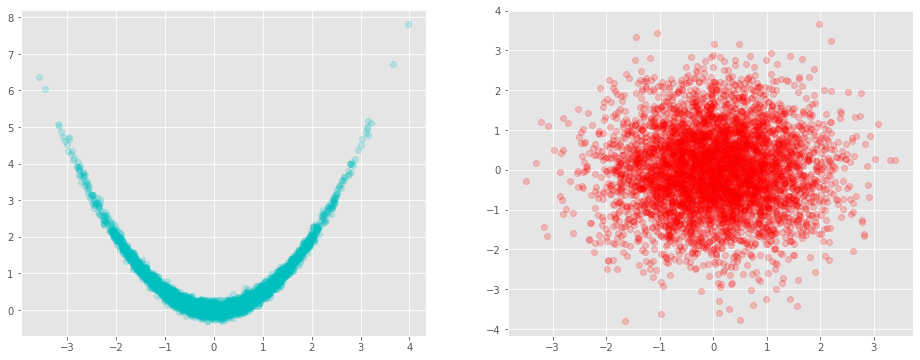

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target = RotatedBanana(num_samples, 0.0)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object
nvp = NVP(num_layers=2, neuron_list=[500,500])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

In [4]:
# Define training options
n_epochs = 150
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 2.4240
Epoch 2/150
100/100 [==============================] - 1s 9ms/step - Negative Log Likelihood: 2.1556
Epoch 3/150
100/100 [==============================] - 1s 9ms/step - Negative Log Likelihood: 1.9191
Epoch 4/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 1.6832
Epoch 5/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.4481
Epoch 6/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 1.2436
Epoch 7/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 1.0893
Epoch 8/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.9872
Epoch 9/150
100/100 [==============================] - 1s 11ms/step - Negative Log Likelihood: 0.8919
Epoch 10/150
100/100 [==============================] - 1s 9ms/step - Negative Log Likelih

100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5552
Epoch 82/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5532
Epoch 83/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5552
Epoch 84/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.5530
Epoch 85/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5576
Epoch 86/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.5541
Epoch 87/150
100/100 [==============================] - 1s 7ms/step - Negative Log Likelihood: 0.5521
Epoch 88/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.5474
Epoch 89/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 0.5548
Epoch 90/150
100/100 [==============================] - 1s 8ms/step - Negative Log Likelihood: 

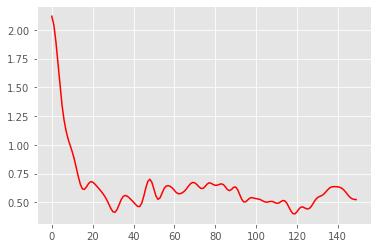

In [5]:
from scipy.ndimage.filters import gaussian_filter1d
ysmoothed = gaussian_filter1d(history.history['Negative Log Likelihood'], sigma=2)
plt.plot(ysmoothed, color = 'r')

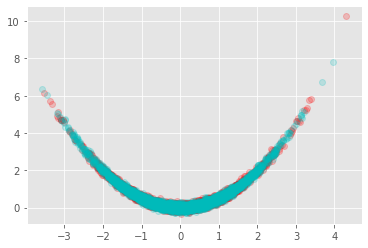

In [6]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.plot(target[:,0], target[:,1], 'co', alpha = .2)

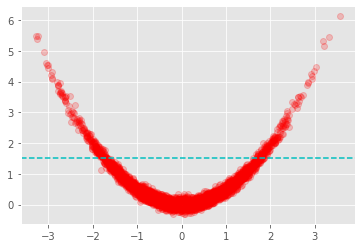

In [7]:
# We want to draw condition samples from about y = 0.0
y_star = 1.5

forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')

In [8]:
rto = RTO_MH(nvp, 2, 1, 10, tf.eye(1))

In [9]:
acc, samples = rto.run()

Acceptance Rate: 0.9


[(-3.0, 3.0)]

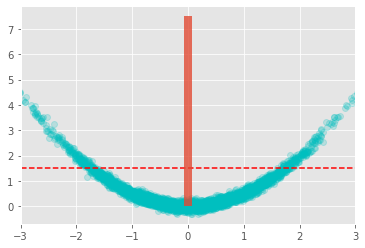

In [12]:
# Plot the conditional samples
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples[0,:], 150, (-5, 5), alpha=.8, density=True, zorder=10)
ax.axhline(y=y_star, color='r', linestyle='--')
ax.set(xlim=(-3, 3))